## import packages

In [1]:
import numpy as np
import pandas as pd
from typing import Optional, Tuple
import sys

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

from pickle import dump
from sklearn.preprocessing import MinMaxScaler
import time
from tqdm import tqdm

import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import os

device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("cuda is available")
else:
    print("cuda is NOT available")

device = torch.device("cuda:0")


import shutil
import warnings
import pickle

warnings.filterwarnings("ignore")
import logging

logging.disable(logging.CRITICAL)

from nn_functions import surrogate
from moving_average import moving_average_1d
import copy
from GAMMA_obj_temp_depth import GAMMA_obj

import sys
sys.path.append('../1_model')
from TiDE import TideModule, quantile_loss, TiDE_forward

import importlib
import policy
importlib.reload(policy)
from policy import PolicyNN


cuda is available


## define funcitons

In [2]:
# values from user
x_min = torch.tensor([[0.0, 0.75, 0.75, 504.26]], dtype=torch.float32).to(device)
x_max = torch.tensor([[7.5, 20.0, 20.0, 732.298]], dtype=torch.float32).to(device)

y_min = torch.tensor([[436.608, -0.559]], dtype=torch.float32).to(device)
y_max = torch.tensor([[4509.855, 0.551]], dtype=torch.float32).to(device)


In [3]:
def normalize_x(x, dim_id):
    x_min_selected = x_min[0, dim_id]
    x_max_selected = x_max[0, dim_id]
    return 2 * (x - x_min_selected) / (x_max_selected - x_min_selected) - 1

def inverse_normalize_x(x_norm, dim_id):
    x_min_selected = x_min[0, dim_id]
    x_max_selected = x_max[0, dim_id]
    return 0.5 * (x_norm + 1) * (x_max_selected - x_min_selected) + x_min_selected

def normalize_y(y, dim_id):
    y_min_selected = y_min[0, dim_id]
    y_max_selected = y_max[0, dim_id]
    return 2 * (y - y_min_selected) / (y_max_selected - y_min_selected) - 1

def inverse_normalize_y(y_norm, dim_id):
    y_min_selected = y_min[0, dim_id]
    y_max_selected = y_max[0, dim_id]
    return 0.5 * (y_norm + 1) * (y_max_selected - y_min_selected) + y_min_selected


In [4]:
def run_one_step_policy(GAMMA_obj, policy_model, P, window):
    # Reference trajectory for temperature (original scale)
    mp_temp_ref = GAMMA_obj.ref[GAMMA_obj.MPC_counter:GAMMA_obj.MPC_counter + P]  # [P, 1] or [P]
    mp_temp_ref_t = torch.as_tensor(mp_temp_ref, dtype=torch.float32, device=device).reshape(1, P, 1)  # [1, P, 1]
    # print("mp_temp_ref_t:", mp_temp_ref_t.shape)

    # Past input (original scale)
    mp_temp_past_t = GAMMA_obj.x_past.T.unsqueeze(0).to(device)  # [1, 50, 2]
    laser_past_t = GAMMA_obj.u_past.view(1, -1, 1).to(device)     # [1, 50, 1]
    fix_cov_past = GAMMA_obj.fix_cov_all[GAMMA_obj.MPC_counter - window:GAMMA_obj.MPC_counter, :]
    fix_cov_past_t = torch.as_tensor(fix_cov_past, dtype=torch.float32, device=device).unsqueeze(0)  # [1, 50, 3]

    # print("mp_temp_past_t:", mp_temp_past_t.shape)
    # print("laser_past_t:", laser_past_t.shape)
    # print("fix_cov_past_t:", fix_cov_past_t.shape)

    # Normalize
    fix_cov_past_s = normalize_x(fix_cov_past_t, dim_id=[0, 1, 2])    # assume features 0~2 in x
    laser_past_s = normalize_x(laser_past_t, dim_id=[3])              # laser power at feature 3
    mp_temp_past_s = normalize_y(mp_temp_past_t, dim_id=[0, 1])       # temp and depth
    # print("mp_temp_past_s:", mp_temp_past_s.squeeze(0).cpu().numpy())
    # print("laser_past_s:", laser_past_s.squeeze(0).cpu().numpy())
    # print("fix_cov_past_s:", fix_cov_past_s.squeeze(0).cpu().numpy())


    policy_in_past = torch.cat((fix_cov_past_s, laser_past_s, mp_temp_past_s), dim=2)  # [1, 50, 6]
    # print("policy_in_past:", policy_in_past.shape)

    # Future covariates
    fix_cov_future = GAMMA_obj.fix_cov_all[GAMMA_obj.MPC_counter:GAMMA_obj.MPC_counter + P, :]
    fix_cov_future_t = torch.as_tensor(fix_cov_future, dtype=torch.float32, device=device).unsqueeze(0)  # [1, P, 3]
    fix_cov_future_s = normalize_x(fix_cov_future_t, dim_id=[0, 1, 2])
    mp_temp_ref_s = normalize_y(mp_temp_ref_t, dim_id=[0])[:, :, 0].unsqueeze(-1)

    # Constraints!
    depth_lower_const = 0*0.1423
    depth_upper_const = 0*0.4126
    y_const_s = torch.tensor([[depth_lower_const, depth_upper_const]] * P, dtype=torch.float32, device=device).reshape(1, P, 2)

    policy_in_future = torch.cat((fix_cov_future_s, mp_temp_ref_s, y_const_s), dim=2)  # [1, P, 6]
    # print("policy_in_future:", policy_in_future.shape)

    # Policy inference
    u_pred = policy_model((policy_in_past, policy_in_future))
    u_first = u_pred[0,0]
    u_applied = float(inverse_normalize_x(u_first, dim_id=[3]))  # laser power
    # print("u_applied (original scale):", u_applied)

    # Simulate one step
    x_current, depth_current = GAMMA_obj.run_sim_interval(u_applied)
    # print("x_current, depth_current:", x_current, depth_current)

    # Update past sequence
    GAMMA_obj.x_past[:, :-1] = GAMMA_obj.x_past[:, 1:]
    GAMMA_obj.x_past[0, -1] = x_current
    GAMMA_obj.x_past[1, -1] = depth_current

    GAMMA_obj.u_past[:-1] = GAMMA_obj.u_past[1:].clone()
    GAMMA_obj.u_past[-1] = u_applied

    # Save state
    GAMMA_obj.x_hat_current = torch.tensor([x_current, depth_current], device=device)
    GAMMA_obj.x_sys_current = torch.tensor([[x_current], [depth_current]], device=device)
    GAMMA_obj.MPC_counter += 1

    # FIXED: device-matched saving
    new_state = torch.tensor([[x_current, depth_current]], device=GAMMA_obj.x_past_save.device)
    GAMMA_obj.x_past_save = torch.cat((GAMMA_obj.x_past_save, new_state), dim=0)

    new_u = torch.tensor([[u_applied]], device=GAMMA_obj.u_past_save.device)
    GAMMA_obj.u_past_save = torch.cat((GAMMA_obj.u_past_save, new_u), dim=0)


In [5]:
import matplotlib.pyplot as plt
import numpy as np

def plot_fig(MPC_GAMMA, N_step, save_path=None):
    plt.figure(figsize=[8, 6])

    plt.subplot(3, 1, 1)
    plt.plot(MPC_GAMMA.x_past_save[:N_step, 0].detach().cpu().numpy(), label="GAMMA simulation")
    plt.plot(MPC_GAMMA.ref[:N_step].detach().cpu().numpy(), label="Reference")
    plt.legend()
    plt.xlabel("MPC time step (*** sec/iteration)")
    plt.ylabel("Melt Pool Temperature (K)")

    plt.subplot(3, 1, 2)
    plt.plot(MPC_GAMMA.x_past_save[:N_step, 1].detach().cpu().numpy(), label="GAMMA simulation")
    plt.plot(np.linspace(0, N_step, N_step), 0.225 * np.ones(N_step), linestyle='--', label="Upper Bound")
    plt.plot(np.linspace(0, N_step, N_step), 0.075 * np.ones(N_step), linestyle='--', label="Lower Bound")
    plt.xlabel("MPC time step (*** sec/iteration)")
    plt.ylabel("Melt Pool Depth (mm)")
    plt.legend()

    plt.subplot(3, 1, 3)
    plt.plot(MPC_GAMMA.u_past_save[:N_step].detach().cpu().numpy())
    plt.ylabel("Laser Power (W)")
    plt.xlabel("MPC time step (*** sec/iteration)")

    if save_path:
        plt.tight_layout()
        plt.savefig(save_path)
        plt.close()
        print(f"Saved plot to {save_path}")
    else:
        plt.tight_layout()
        plt.show()


## run loop

100%|██████████| 250/250 [00:11<00:00, 22.43it/s]


[DEBUG] laser 18 save types:
  x_past_save: <class 'torch.Tensor'>
  u_past_save: <class 'torch.Tensor'>
  ref: <class 'torch.Tensor'>


Laser 18:   0%|          | 0/6195 [00:00<?, ?it/s]

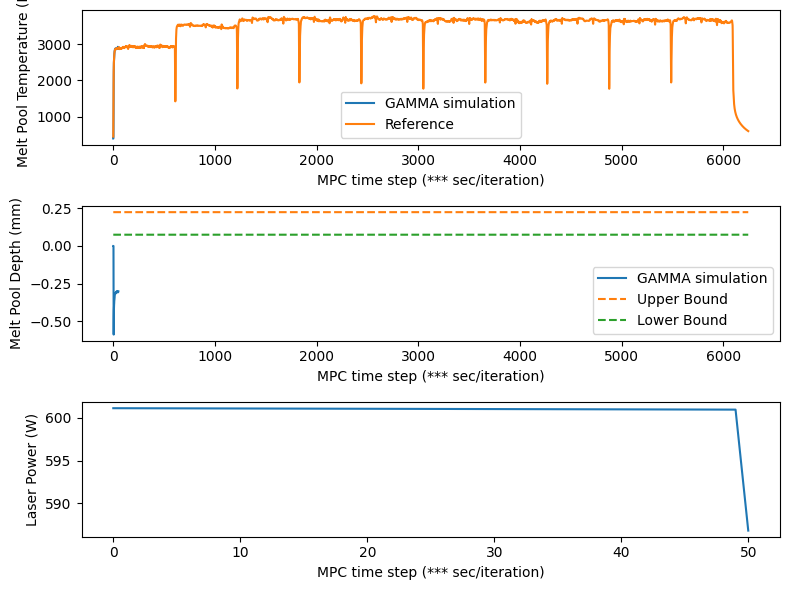

Laser 18:   8%|▊         | 500/6195 [01:53<23:45,  4.00it/s]

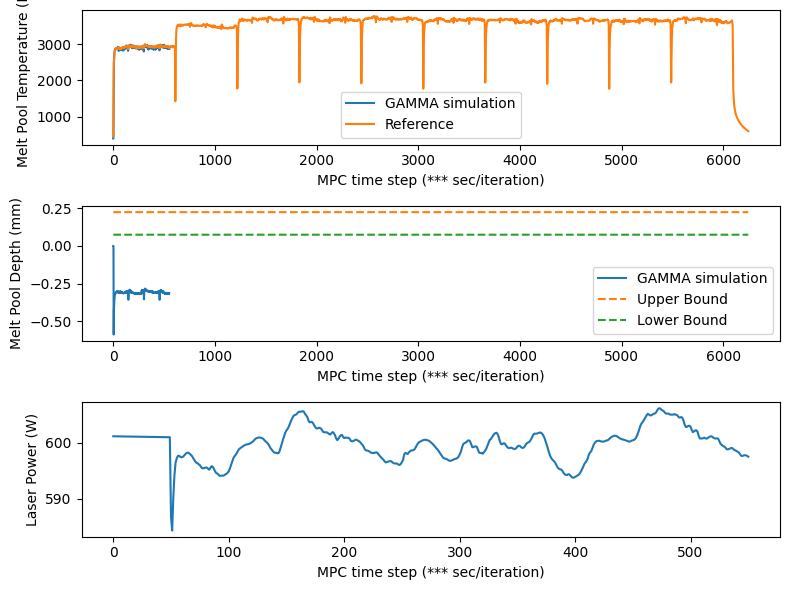

Laser 18:  16%|█▌        | 1000/6195 [03:58<21:11,  4.09it/s]

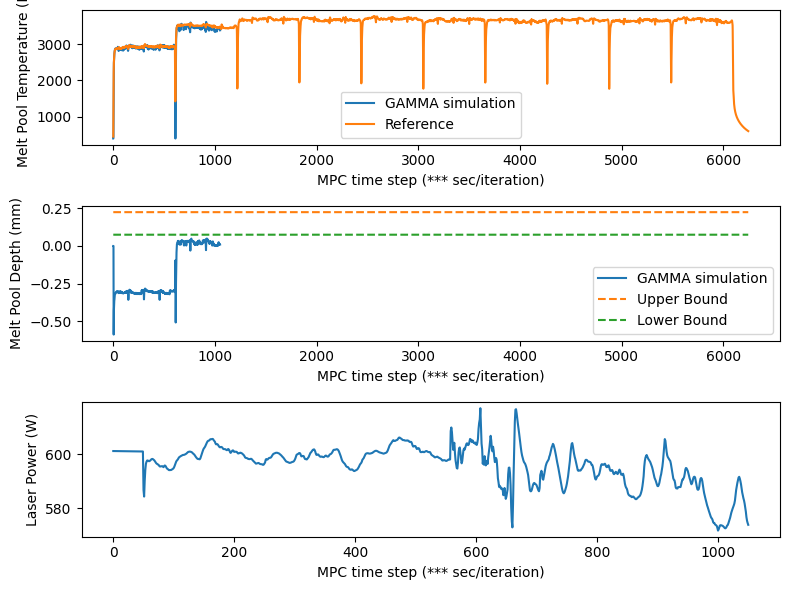

Laser 18:  24%|██▍       | 1500/6195 [05:38<17:33,  4.46it/s]

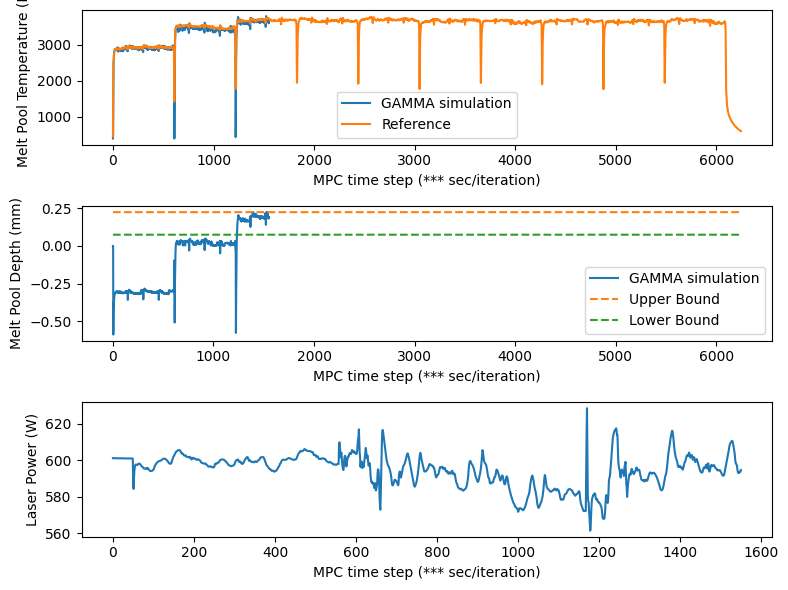

Laser 18:  32%|███▏      | 2000/6195 [07:24<11:34,  6.04it/s]

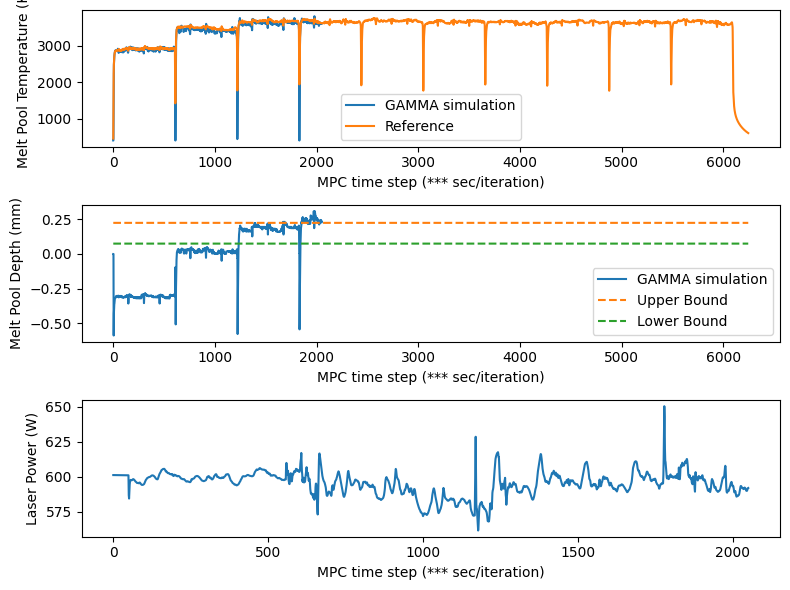

Laser 18:  40%|████      | 2500/6195 [08:49<10:20,  5.96it/s]

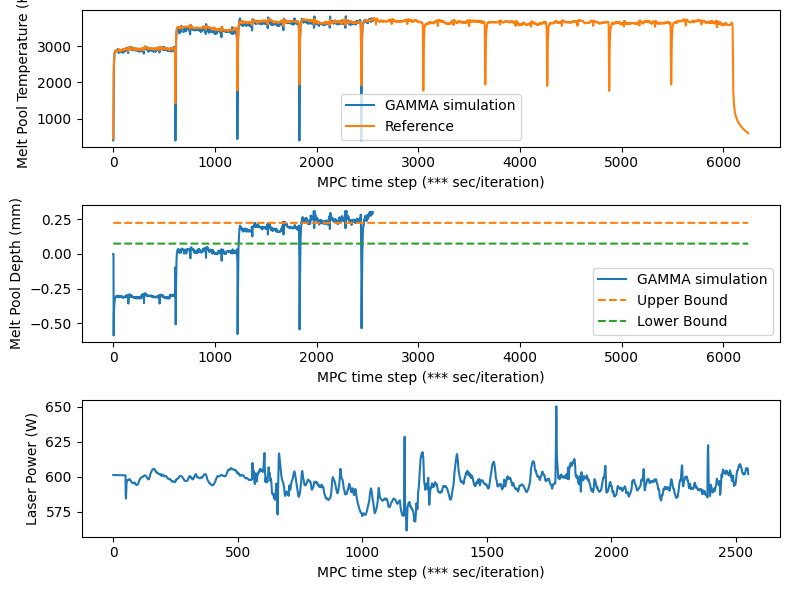

Laser 18:  48%|████▊     | 3000/6195 [10:07<07:03,  7.54it/s]

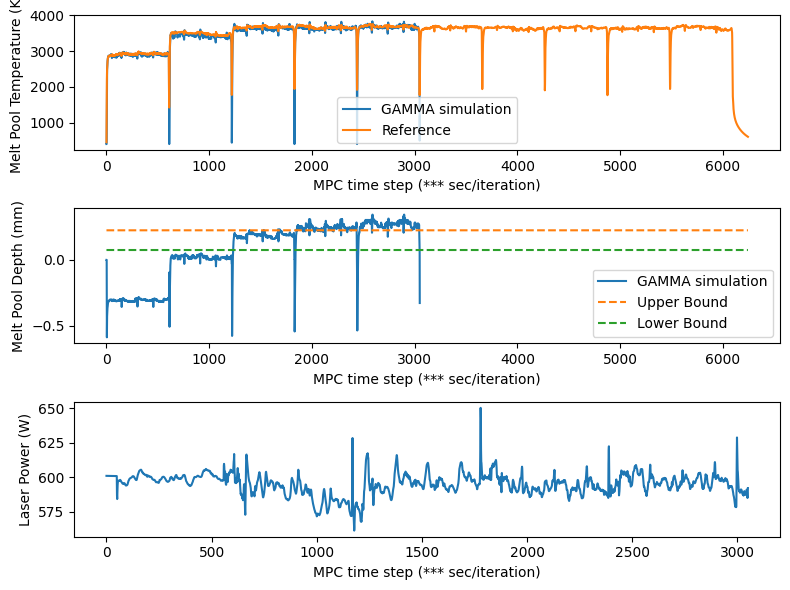

Laser 18:  56%|█████▋    | 3500/6195 [11:20<06:36,  6.79it/s]

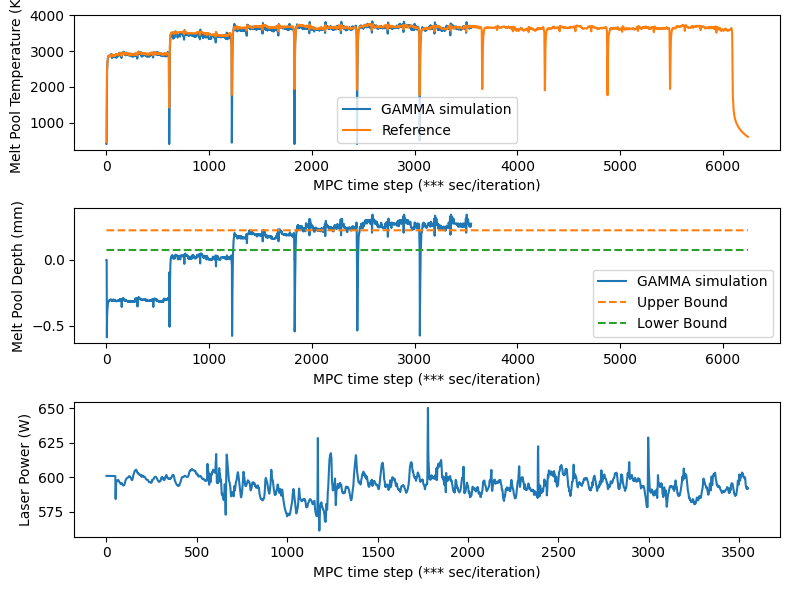

Laser 18:  65%|██████▍   | 4000/6195 [12:34<05:29,  6.66it/s]

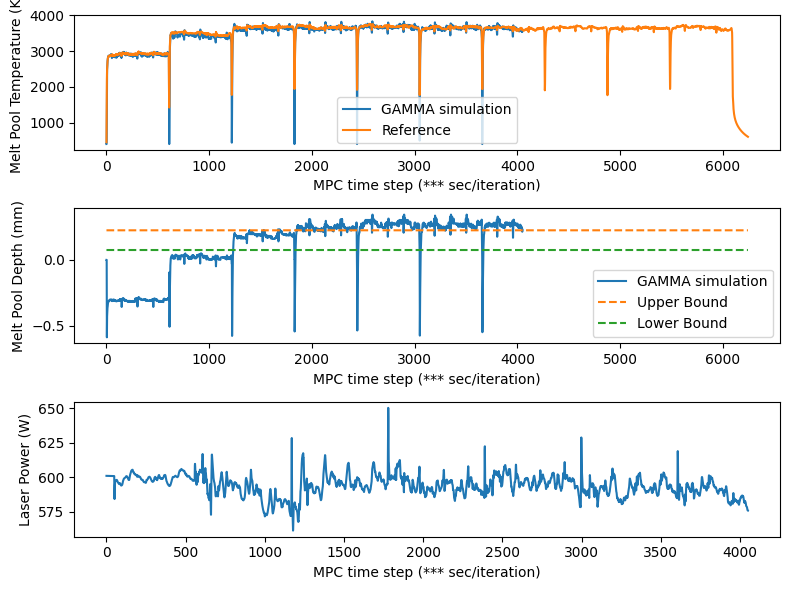

Laser 18:  73%|███████▎  | 4500/6195 [14:04<05:05,  5.55it/s]

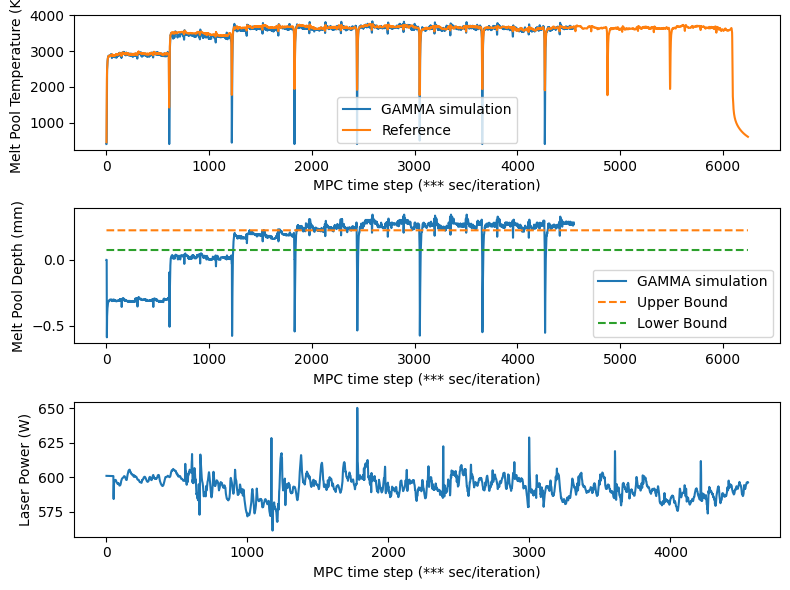

Laser 18:  81%|████████  | 5000/6195 [15:36<04:31,  4.40it/s]

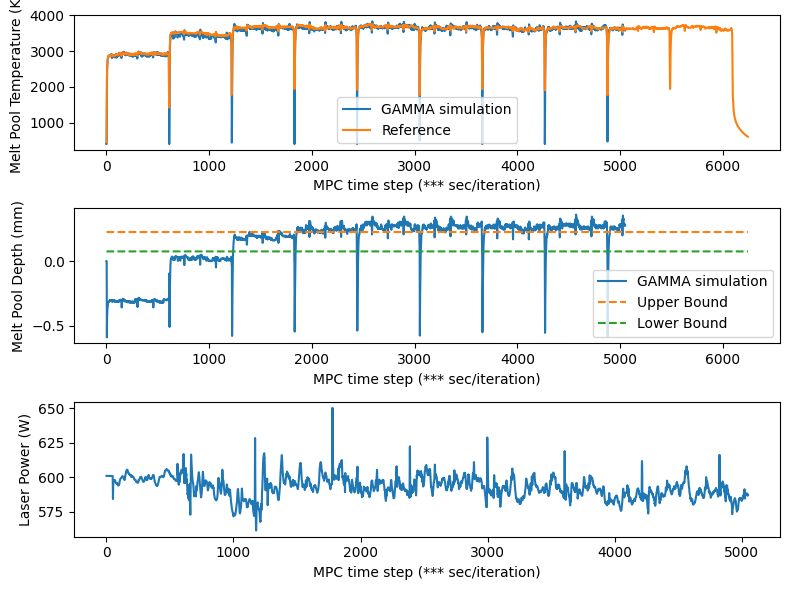

Laser 18:  89%|████████▉ | 5500/6195 [17:08<02:27,  4.72it/s]

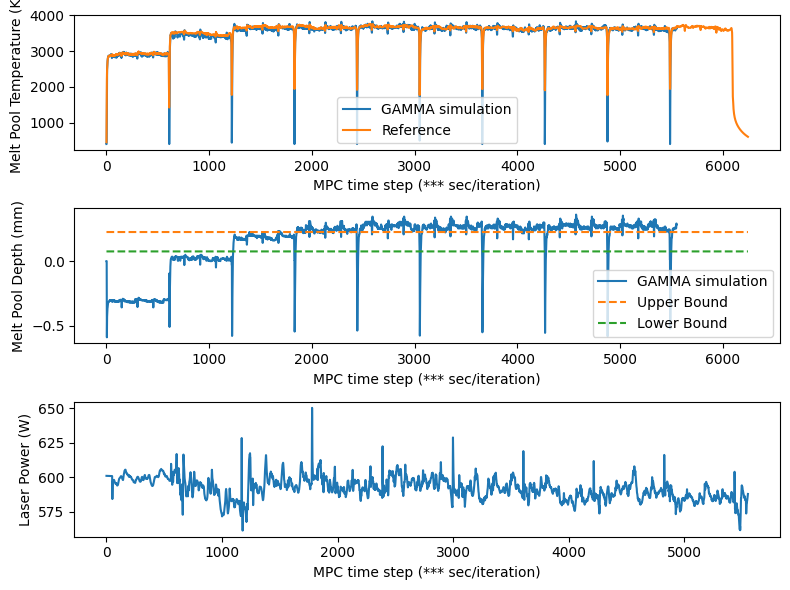

Laser 18:  97%|█████████▋| 6000/6195 [18:43<00:35,  5.44it/s]

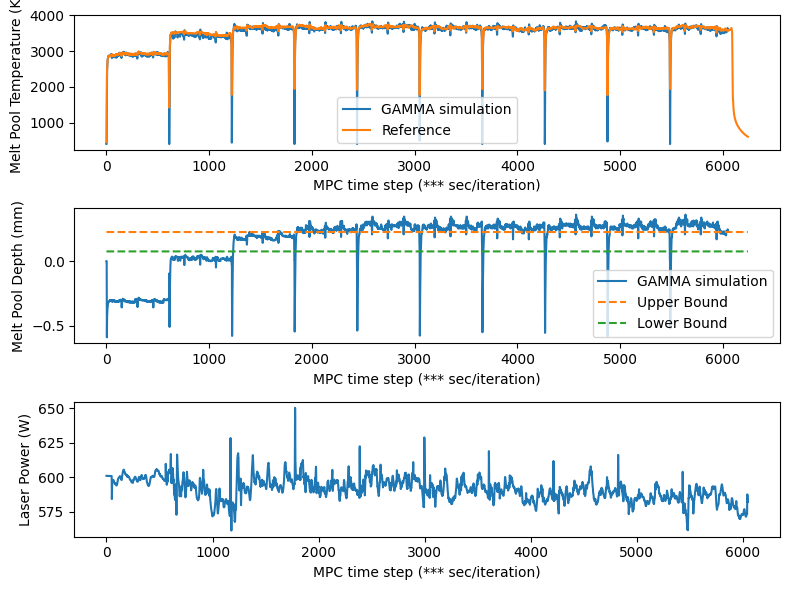

Laser 18: 100%|██████████| 6195/6195 [19:19<00:00,  5.34it/s]


✅ Completed and saved for laser_power_number 18


100%|██████████| 250/250 [00:08<00:00, 30.93it/s]


[DEBUG] laser 19 save types:
  x_past_save: <class 'torch.Tensor'>
  u_past_save: <class 'torch.Tensor'>
  ref: <class 'torch.Tensor'>


Laser 19:   0%|          | 0/6195 [00:00<?, ?it/s]

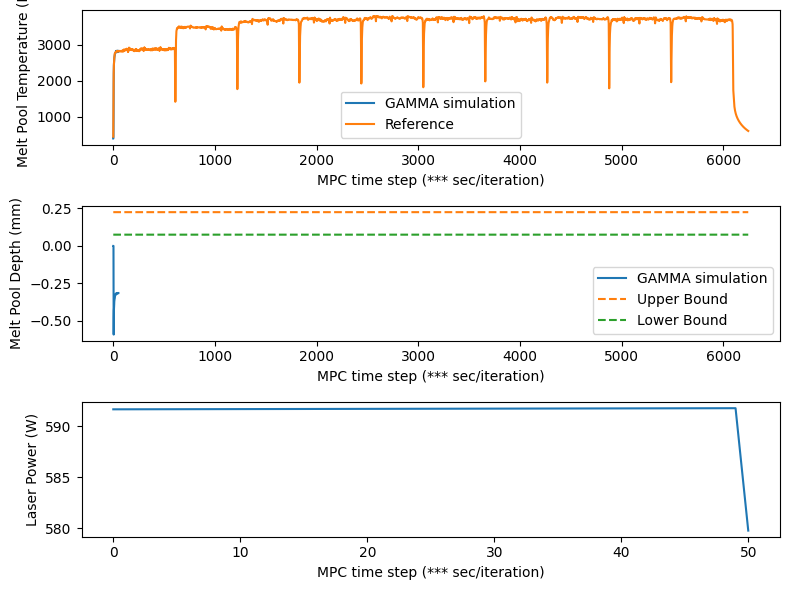

Laser 19:   8%|▊         | 500/6195 [01:25<16:41,  5.69it/s]

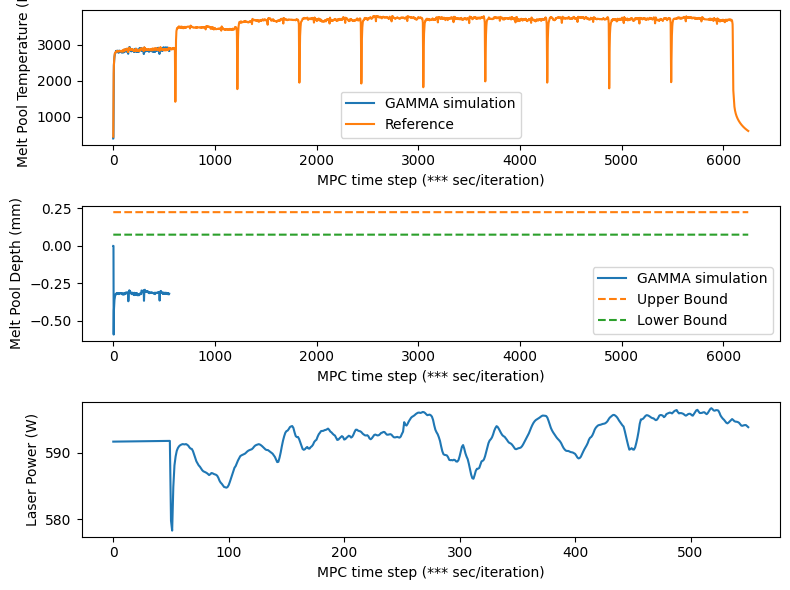

Laser 19:  16%|█▌        | 1000/6195 [02:55<15:38,  5.54it/s]

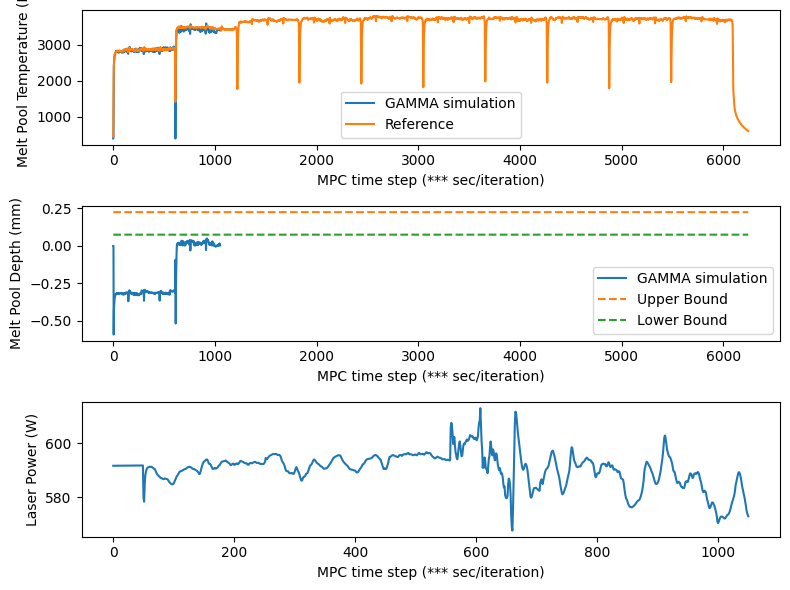

Laser 19:  24%|██▍       | 1500/6195 [04:11<13:24,  5.83it/s]

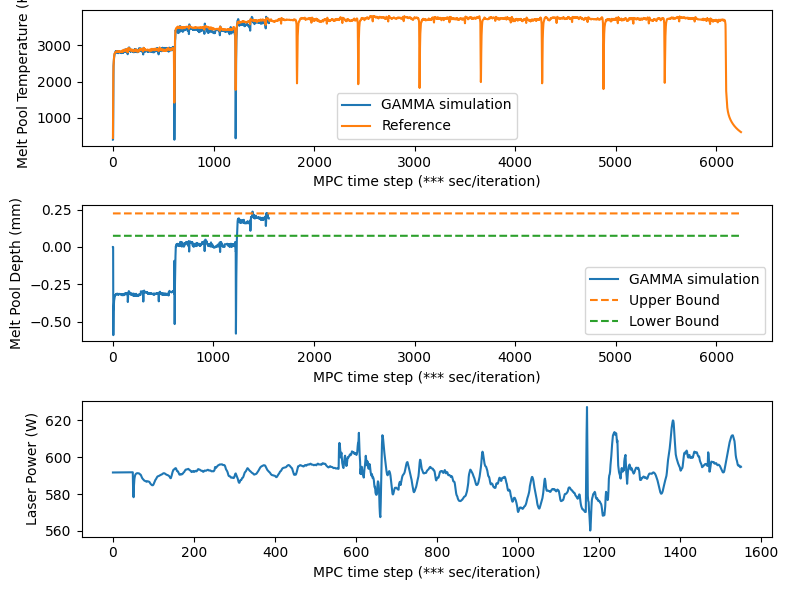

Laser 19:  32%|███▏      | 2000/6195 [05:37<11:38,  6.00it/s]

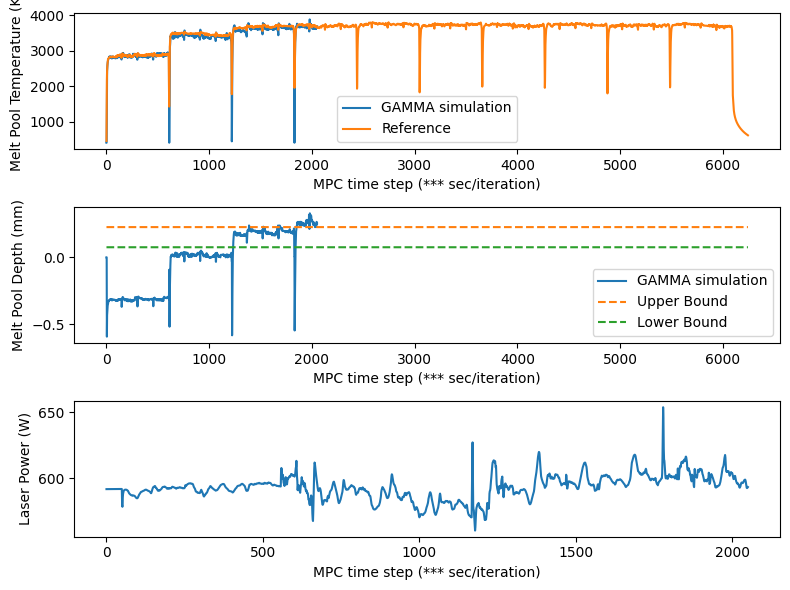

Laser 19:  40%|████      | 2500/6195 [07:02<10:39,  5.78it/s]

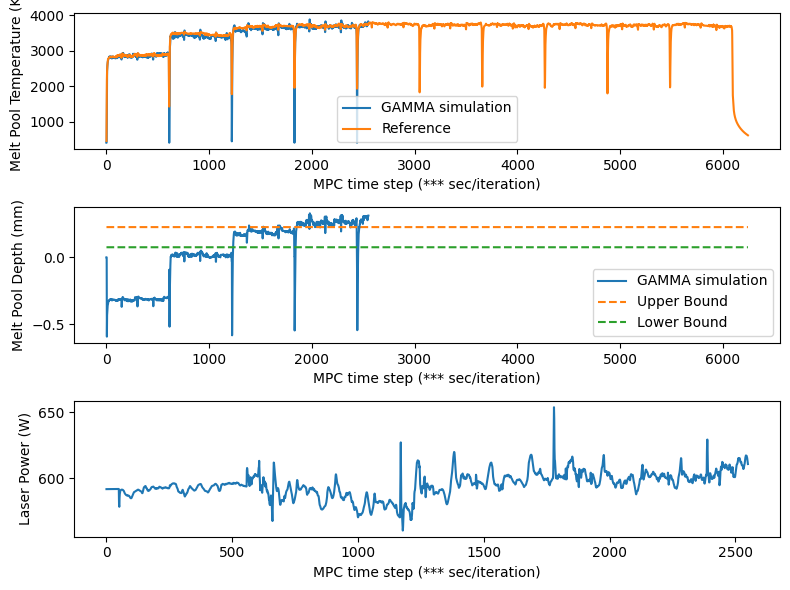

Laser 19:  48%|████▊     | 3000/6195 [08:28<08:27,  6.30it/s]

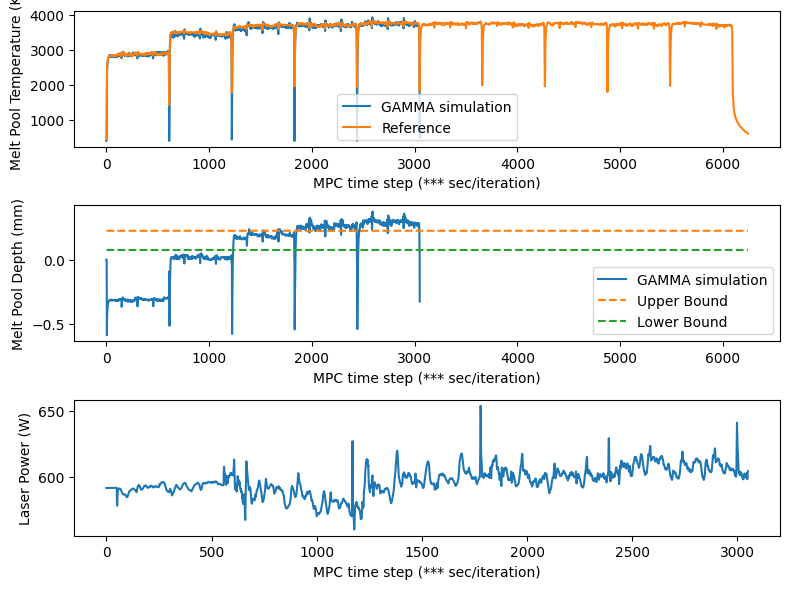

Laser 19:  56%|█████▋    | 3500/6195 [09:51<08:21,  5.37it/s]

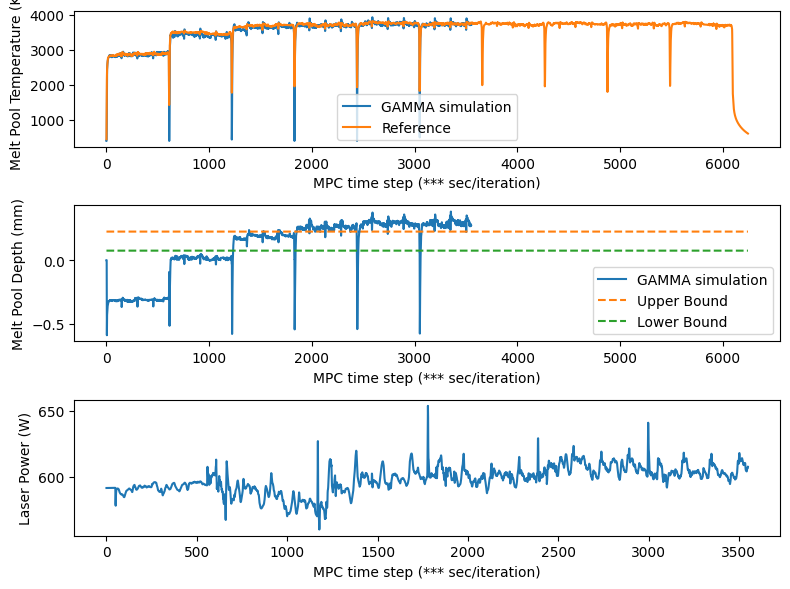

Laser 19:  65%|██████▍   | 4000/6195 [11:24<07:05,  5.16it/s]

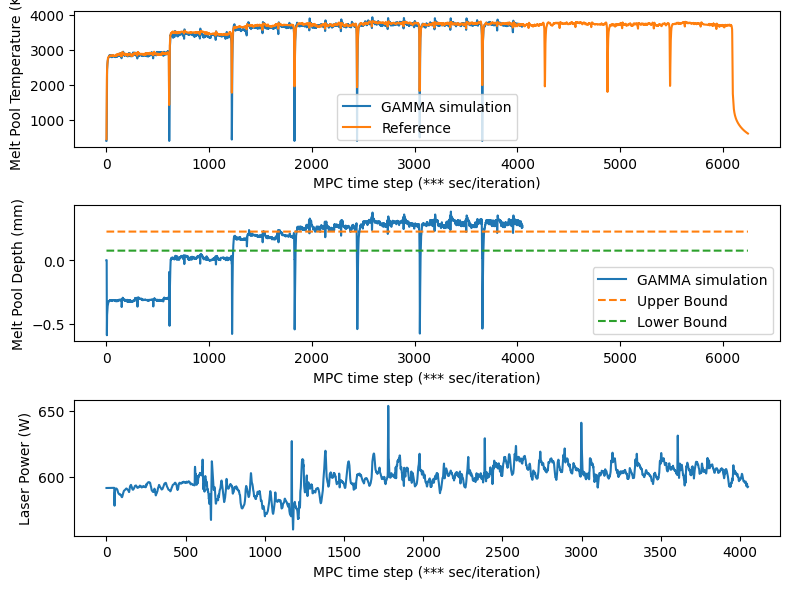

Laser 19:  73%|███████▎  | 4500/6195 [12:59<05:27,  5.18it/s]

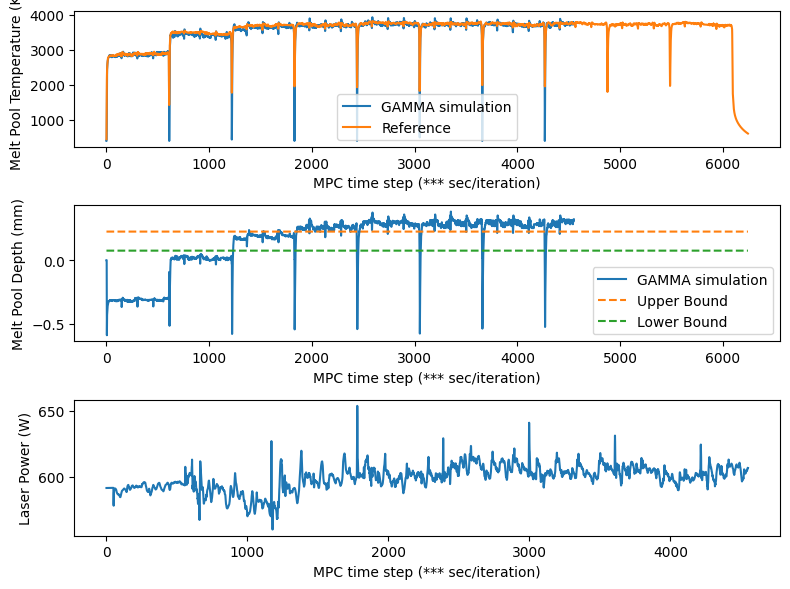

Laser 19:  81%|████████  | 5000/6195 [14:33<03:36,  5.52it/s]

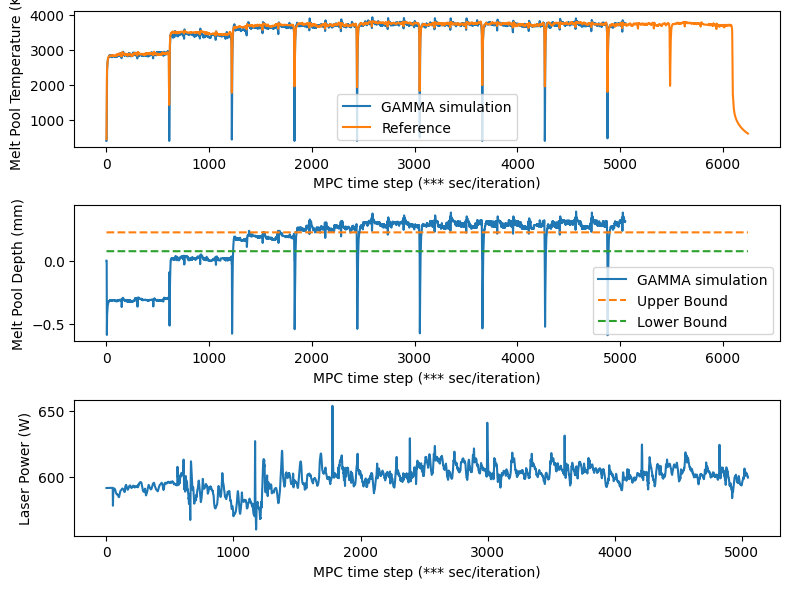

Laser 19:  89%|████████▉ | 5500/6195 [16:08<02:14,  5.15it/s]

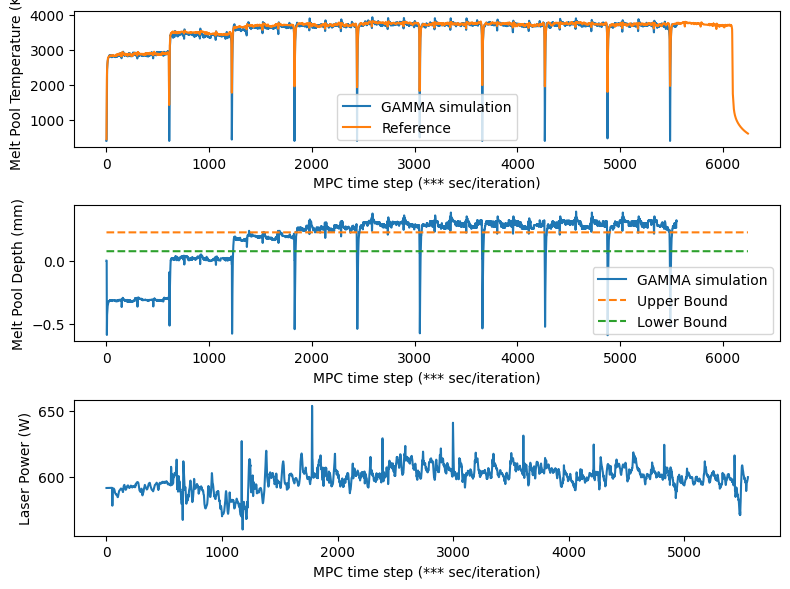

Laser 19:  97%|█████████▋| 6000/6195 [17:42<00:35,  5.50it/s]

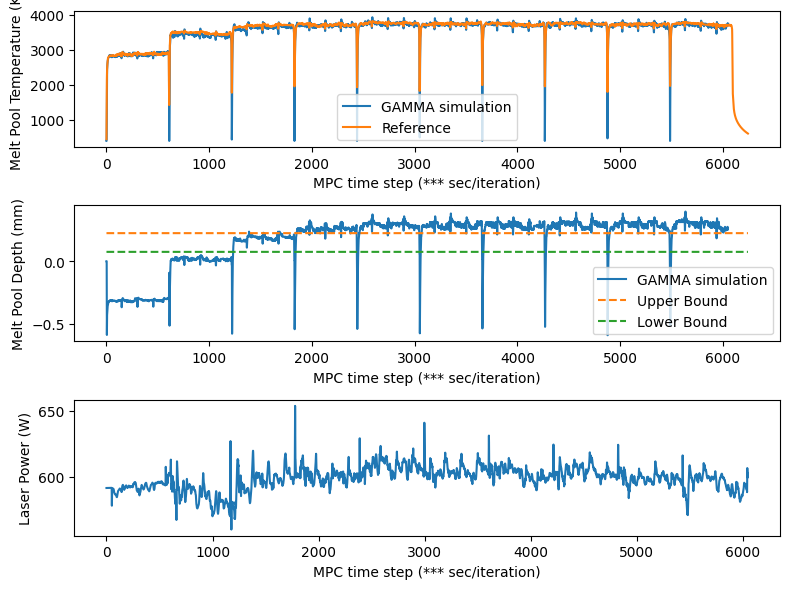

Laser 19: 100%|██████████| 6195/6195 [18:18<00:00,  5.64it/s]


✅ Completed and saved for laser_power_number 19


In [6]:
device = torch.device("cuda:0")

# ── Constants ─────────────────────────────────────
INPUT_DATA_DIR = "data"
SIM_DIR_NAME = "single_track_square"
BASE_LASER_FILE_DIR = "laser_power_profiles/csv"
CLOUD_TARGET_BASE_PATH = "result"
solidus_temp = 1600
window = 50
sim_interval = 5
init_runs = 50
P = 50

model_path = "/home/ftk3187/github/DPC_research/02_DED/4_policy_0725/trainresults/policy_model_discreteshift_3L_1024H_s1_c0_case19.pth"

# ── Load model ─────────────────────────────────────
model = PolicyNN(
    past_input_dim=6,
    future_input_dim=6,
    output_dim=1,
    p=P,
    window=window,
    hidden_dim=1024,
    n_layers=3,
    dropout_p=0.1
).to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

# ── Output directory ───────────────────────────────
save_dir = "/home/ftk3187/github/DPC_research/02_DED/4_policy_0725/simulation_outputs_case19_discrete shift" \
""
os.makedirs(save_dir, exist_ok=True)

# ── Loop over laser_power_number 2 to 30 ───────────
for laser_num in range(18,20):
    try:
        # Step 1: Load input CSV
        csv_path = f"/home/ftk3187/github/DPC_research/02_DED/4_policy_0725/split_by_laser_power_number/laser_power_number_{laser_num}.csv"
        df = pd.read_csv(csv_path)

        # Step 2: Instantiate GAMMA class
        GAMMA_class = GAMMA_obj(INPUT_DATA_DIR, SIM_DIR_NAME, BASE_LASER_FILE_DIR,
                                CLOUD_TARGET_BASE_PATH, solidus_temp, window,
                                init_runs, sim_interval, laser_power_number=laser_num)

        # Step 3: Run initial steps
        init_avg = GAMMA_class.run_initial_steps()
        init_avg = torch.tensor(init_avg, dtype=torch.float32).to(device)[:, -window:]

        # Step 4: Prepare inputs
        loc_Z = df["Z"].to_numpy().reshape(-1, 1)
        dist_X = df["Dist_to_nearest_X"].to_numpy().reshape(-1, 1)
        dist_Y = df["Dist_to_nearest_Y"].to_numpy().reshape(-1, 1)
        fix_covariates = torch.tensor(np.concatenate((loc_Z, dist_X, dist_Y), axis=1), dtype=torch.float32).to(device)

        laser_power_ref = torch.tensor(df["Laser_power"].to_numpy().reshape(-1, 1), dtype=torch.float32).to(device)
        laser_power_past = laser_power_ref[:window]

        mp_temp_raw = df["melt_pool_temperature"].to_numpy()
        mp_temp = copy.deepcopy(mp_temp_raw)
        mp_temp[1:-2] = moving_average_1d(mp_temp_raw, 4)
        mp_temp_ref = torch.tensor(mp_temp, dtype=torch.float32).to(device)

        mp_depth_raw = df["melt_pool_depth"].to_numpy()
        mp_depth = copy.deepcopy(mp_depth_raw)
        mp_depth[1:-2] = moving_average_1d(mp_depth_raw, 4)
        mp_depth_ref = torch.tensor(mp_depth, dtype=torch.float32).to(device)

        # Step 5: Initialize GAMMA_class variables
        GAMMA_class.ref = mp_temp_ref.clone()
        GAMMA_class.fix_cov_all = fix_covariates.clone()
        GAMMA_class.x_past = init_avg.clone()
        GAMMA_class.u_past = laser_power_past.clone()
        GAMMA_class.x_past_save = GAMMA_class.x_past.T.clone()
        GAMMA_class.u_past_save = GAMMA_class.u_past.clone()
        GAMMA_class.MPC_counter = window
        GAMMA_class.x_hat_current = GAMMA_class.x_past[:, -1]
        GAMMA_class.x_sys_current = GAMMA_class.x_past[:, -1].reshape(2, 1)

        print(f"[DEBUG] laser {laser_num} save types:")
        print("  x_past_save:", type(GAMMA_class.x_past_save))
        print("  u_past_save:", type(GAMMA_class.u_past_save))
        print("  ref:", type(GAMMA_class.ref))


        # Step 6: Run simulation loop
        N_step = len(mp_temp_ref) - P
        for i in tqdm(range(N_step - P), desc=f"Laser {laser_num}"):
            run_one_step_policy(GAMMA_class, model, P=P, window=window)
            if i % 500 == 0:
                plot_fig(GAMMA_class, N_step)

        # Step 7: Save outputs
        x_save = GAMMA_class.x_past_save.detach().cpu().numpy()
        u_save = GAMMA_class.u_past_save.detach().cpu().numpy()
        ref_save = GAMMA_class.ref.detach().cpu().numpy()

        pd.DataFrame(x_save).to_csv(
            os.path.join(save_dir, f"x_outputs_laser_{laser_num}.csv"), index=False)
        pd.DataFrame(u_save).to_csv(
            os.path.join(save_dir, f"u_outputs_laser_{laser_num}.csv"), index=False)
        pd.DataFrame(ref_save).to_csv(
            os.path.join(save_dir, f"ref_laser_{laser_num}.csv"), index=False)


        print(f"✅ Completed and saved for laser_power_number {laser_num}")

    except Exception as e:
        print(f"❌ Error in laser_power_number {laser_num}: {e}")
